In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks

In [2]:
using Plots

In [3]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [4]:
using Statistics: mean

In [5]:
offsets = 0.0:0.25:1.0 |> collect

5-element Vector{Float64}:
 0.0
 0.25
 0.5
 0.75
 1.0

In [6]:
phases = reshape(-1.0:0.01:1.0 |> collect, (1, :))

1×201 Matrix{Float64}:
 -1.0  -0.99  -0.98  -0.97  -0.96  …  0.95  0.96  0.97  0.98  0.99  1.0

In [7]:
length((1,2,3))

3

In [8]:
Int64 <: Int

true

In [9]:
t = phase_to_train(phases, spk_args=sa, repeats = 5)

Spike Train: (1, 201) with 1005 spikes.

In [11]:
typeof(t) <: SpikeTrain{2}

true

In [9]:
t2 = t[1, [collect(20:30)...]]

Spike Train: (1, 11) with 55 spikes.

In [10]:
t2.indices

55-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(1, 2)
 CartesianIndex(1, 3)
 CartesianIndex(1, 4)
 CartesianIndex(1, 5)
 CartesianIndex(1, 6)
 CartesianIndex(1, 7)
 CartesianIndex(1, 8)
 CartesianIndex(1, 9)
 CartesianIndex(1, 10)
 CartesianIndex(1, 11)
 CartesianIndex(1, 1)
 CartesianIndex(1, 2)
 ⋮
 CartesianIndex(1, 11)
 CartesianIndex(1, 1)
 CartesianIndex(1, 2)
 CartesianIndex(1, 3)
 CartesianIndex(1, 4)
 CartesianIndex(1, 5)
 CartesianIndex(1, 6)
 CartesianIndex(1, 7)
 CartesianIndex(1, 8)
 CartesianIndex(1, 9)
 CartesianIndex(1, 10)
 CartesianIndex(1, 11)

In [11]:
sz = size(t)

(1, 201)

In [12]:
ci = CartesianIndices(size(t))

CartesianIndices((1, 201))

In [13]:
inds = (1,[3,8,9])

(1, [3, 8, 9])

In [14]:
sel = getindex(ci, inds...)

3-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 3)
 CartesianIndex(1, 8)
 CartesianIndex(1, 9)

In [15]:
size(sel)

(3,)

In [16]:
[idx in sel for idx in t.indices]

1005-element Vector{Bool}:
 0
 0
 1
 0
 0
 0
 0
 1
 1
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [17]:
function remap(indices::Vector{<:CartesianIndex})
    #find the dimensions of unique elements for the new array
    n_dims = length(indices[1])
    elements = [map(x -> getindex(x, i), indices) for i in 1:n_dims]
    unique_elements = unique.(elements)
    new_ranges = [1:length(e) for e in unique_elements]
    #for each dimension and element, construct the map of old to new elements
    match = (x, i) -> x => new_ranges[i][findfirst(unique_elements[i] .== x)[1]]
    mapping = [Dict(match.(elements[i], i)) for i in 1:n_dims]

    #map each old index to the new index
    new_indices = map(idx -> CartesianIndex([mapping[i][idx[i]] for i in 1:n_dims]...), indices)
    new_shape = Tuple([r[end] for r in new_ranges])
    return new_indices, new_shape
end

remap (generic function with 1 method)

In [18]:
r1, s1 = remap(sel)

(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 2), CartesianIndex(1, 3)], (1, 3))

In [19]:
r1

3-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 1)
 CartesianIndex(1, 2)
 CartesianIndex(1, 3)

In [20]:
s1

(1, 3)

In [21]:
function Base.getindex(x::SpikeTrain, inds...)
    #find the relevant entries
    idxs = CartesianIndices(size(x))
    selected = idxs[inds...]
    matches = [idx in selected for idx in x.indices]
    #downselect
    sel_indices = x.indices[matches]
    sel_times = x.times[matches]
    #map the old indicies to new values
    new_inds = remap(sel_indices)
    new_train = SpikeTrain(new_inds, sel_times, x.shape, x.offset)

    return new_train
end

In [22]:
# phase to time

In [23]:
tms = [phase_to_time(phases, spk_args=sa, offset=o) for o in offsets]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0050000000000000044 … 0.995 0.0]
 [0.25 0.255 … 0.2450000000000001 0.25]
 [0.5 0.505 … 0.4950000000000001 0.5]
 [0.75 0.755 … 0.7450000000000001 0.75]
 [0.0 0.004999999999999893 … 0.9950000000000001 0.0]

In [24]:
phase_tms = [time_to_phase(tms[i], spk_args=sa, offset=o) for (i,o) in enumerate(offsets)]

5-element Vector{Matrix{Float64}}:
 [-1.0 -0.99 … 0.99 -1.0]
 [-1.0 -0.99 … 0.9900000000000002 -1.0]
 [-1.0 -0.99 … 0.9900000000000002 -1.0]
 [-1.0 -0.99 … 0.9900000000000002 -1.0]
 [-1.0 -0.9900000000000002 … 0.9900000000000002 -1.0]

In [25]:
e0 = [maximum(arc_error(phases .- p)) for p in phase_tms]

5-element Vector{Float64}:
 3.487868498008632e-16
 6.975736996017264e-16
 8.719671245021579e-16
 8.719671245021579e-16
 8.719671245021579e-16

In [26]:
# phase to train

In [27]:
trains = [phase_to_train(phases, spk_args=sa, offset=o) for o in offsets];

In [28]:
trains[1]

Spike Train: (1, 201) with 201 spikes.

In [79]:
function increment_indices(indices::Vector{CartesianIndex{N}}, dim::Int, value::Int) where N
    # Check if the dimension is valid
    if dim < 1 || dim > N
        error("Invalid dimension. Must be between 1 and $N.")
    end

    # Increment the indices along the specified dimension
    return [CartesianIndex(ntuple(i -> i == dim ? idx[i] + value : idx[i], Val(N))) for idx in indices]
end

function Base.cat(x::SpikeTrain...; dim)
    n_trains = length(x)

    inds = x[1].indices |> deepcopy
    tms = x[1].times |> deepcopy
    offset = x[1].offset
    n_dims = length(x[1].shape)

    if n_trains > 1
        i = 2

        for i in 2:n_trains
            #calculate how far the indices need to be shifted
            selected = getindex.(inds, dim)
            idx_offset = maximum(selected)
            
            #offset the indices
            new_inds = increment_indices(x[i].indices, dim, idx_offset)
            #append them to the new train
            append!(inds, new_inds)
            append!(tms, x[i].times)
            @assert x[i].offset == offset "Spike trains must have idential offset to concatentate"
        end
    end

    shape = Tuple([maximum(getindex.(inds, i)) for i in 1:n_dims])

    #create and return the new train
    new_train = SpikeTrain(inds, tms, shape, offset)
end

In [80]:
trains2 = [phase_to_train(rand(Float64, (40, 10)) .* 2 .- 1, spk_args=sa, offset=0.0) for o in offsets];

In [81]:
trains2

5-element Vector{SpikeTrain}:
 Spike Train: (40, 10) with 400 spikes.
 Spike Train: (40, 10) with 400 spikes.
 Spike Train: (40, 10) with 400 spikes.
 Spike Train: (40, 10) with 400 spikes.
 Spike Train: (40, 10) with 400 spikes.

In [82]:
at = cat(trains2..., dim=2)

Spike Train: (40, 50) with 2000 spikes.

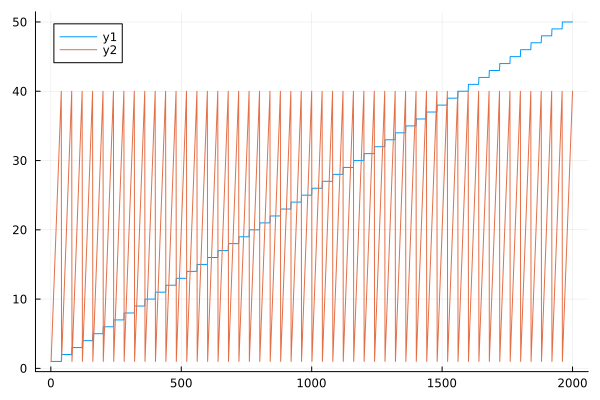

In [85]:
plot(getindex.(at.indices, 2))
plot!(getindex.(at.indices, 1)) 

In [83]:
at2 = cat(trains2..., dim=2)

Spike Train: (40, 50) with 2000 spikes.

In [47]:
trains

5-element Vector{SpikeTrain}:
 Spike Train: (1, 201) with 201 spikes.
 Spike Train: (1, 201) with 201 spikes.
 Spike Train: (1, 201) with 201 spikes.
 Spike Train: (1, 201) with 201 spikes.
 Spike Train: (1, 201) with 201 spikes.

In [14]:
train_to_phase(trains[2], sa)

1×201 Matrix{Float64}:
 -1.0  -0.99  -0.98  -0.97  -0.96  …  0.95  0.96  0.97  0.98  0.99  -1.0

In [15]:
function wrapper(t)
    println(t)
    return train_to_phase(t, sa)
end

wrapper (generic function with 1 method)

In [16]:
import .PhasorNetworks: train_to_phase

In [17]:
function train_to_phase(train::SpikeTrain, spk_args::SpikingArgs)
    if length(train.times) == 0
        return missing
    end

    @assert reduce(*, train.times .>= 0.0) "Spike train times must be positive"

    #decode each spike's phase within a cycle
    relative_phase = time_to_phase(train.times, spk_args.t_period, train.offset)
    relative_time = train.times .- train.offset
    #what is the cycle in which each spike occurs?
    cycle = floor.(Int, relative_time .÷ spk_args.t_period)
    #re-number cycles to be positive
    cycle = cycle .+ (1 - minimum(cycle))
    #what is the number of cycles in this train?
    n_cycles = maximum(cycle)
    phases = [NaN .* zeros(train.shape...) for i in 1:n_cycles]

    for i in eachindex(relative_phase)
        phases[cycle[i]][train.indices[i]] = relative_phase[i]
    end

    #stack the arrays to cycle, batch, neuron
    phases = mapreduce(x->reshape(x, 1, train.shape...), vcat, phases)
    return phases
end


train_to_phase (generic function with 3 methods)

In [18]:
rec_phases = [wrapper(t) for t in trains];

Spike Train: (201,) with 201 spikes.
Spike Train: (201,) with 201 spikes.
Spike Train: (201,) with 201 spikes.
Spike Train: (201,) with 201 spikes.
Spike Train: (201,) with 201 spikes.


In [19]:
e1 = [mapslices(x -> x .- phases, t, dims=(2)) for t in rec_phases]

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 -2.0]
 [0.0 0.0 … 2.220446049250313e-16 -2.0]
 [0.0 0.0 … 2.220446049250313e-16 -2.0]
 [0.0 0.0 … 2.220446049250313e-16 -2.0]
 [0.0 NaN … NaN -2.0; NaN -2.220446049250313e-16 … 2.220446049250313e-16 NaN]

In [20]:
e2 = map(y -> maximum(arc_error(filter(x -> !isnan(x), y))), e1)

5-element Vector{Float64}:
 3.487868498008632e-16
 6.975736996017264e-16
 1.0027621931774816e-15
 1.0027621931774816e-15
 1.0027621931774816e-15

In [21]:
tms = 0.0:0.1:6.0 |> collect
us = [phase_to_potential(phases, tms, offset = o, spk_args=sa) for o in offsets]

5-element Vector{Matrix{ComplexF64}}:
 [1.0 - 2.4492935982947064e-16im 0.8090169943749471 + 0.5877852522924736im … 0.8090169943749486 - 0.5877852522924716im 1.0 - 1.7145055188062944e-15im; 0.9995065603657316 - 0.03141075907812836im 0.8270805742745618 + 0.5620833778521306im … 0.7901550123756905 - 0.6129070536529763im 0.9995065603657315 - 0.0314107590781316im; … ; 0.9995065603657316 + 0.03141075907812832im 0.7901550123756904 + 0.6129070536529765im … 0.8270805742745599 - 0.5620833778521334im 0.9995065603657316 + 0.031410759078128424im; 1.0 + 0.0im 0.8090169943749475 + 0.5877852522924731im … 0.8090169943749487 - 0.5877852522924714im 1.0 - 1.4695761589768238e-15im]
 [-1.8369701987210297e-16 - 1.0im 0.5877852522924729 - 0.8090169943749476im … -0.587785252292473 - 0.8090169943749475im -3.4296300182491773e-15 - 1.0im; -0.0314107590781283 - 0.9995065603657316im 0.5620833778521306 - 0.8270805742745618im … -0.6129070536529776 - 0.7901550123756894im -0.03141075907812622 - 0.9995065603657316im; … ;

In [22]:
ss = us[1][:,1]

201-element Vector{ComplexF64}:
                1.0 - 2.4492935982947064e-16im
 0.9995065603657316 - 0.03141075907812836im
 0.9980267284282716 - 0.06279051952931326im
   0.99556196460308 - 0.09410831331851491im
 0.9921147013144778 - 0.12533323356430465im
 0.9876883405951377 - 0.15643446504023112im
 0.9822872507286887 - 0.18738131458572468im
 0.9759167619387474 - 0.21814324139654243im
  0.968583161128631 - 0.24868988716485535im
 0.9602936856769432 - 0.2789911060392288im
 0.9510565162951535 - 0.3090169943749476im
 0.9408807689542255 - 0.3387379202452914im
 0.9297764858882511 - 0.3681245526846787im
                    ⋮
 0.9408807689542255 + 0.3387379202452913im
 0.9510565162951536 + 0.30901699437494734im
 0.9602936856769431 + 0.27899110603922916im
 0.9685831611286312 + 0.24868988716485463im
 0.9759167619387474 + 0.2181432413965424im
 0.9822872507286886 + 0.18738131458572477im
 0.9876883405951377 + 0.156434465040231im
 0.9921147013144778 + 0.12533323356430437im
   0.99556196460308 + 0.094

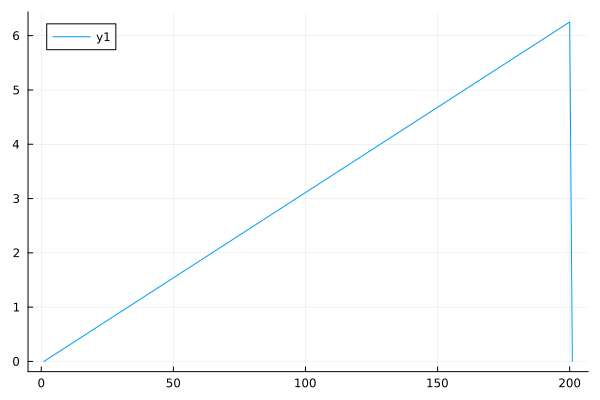

In [23]:
plot(mod.(-1 * angle.(ss), 2*pi))

In [24]:
plot(mod.(-1 * angle.(ss), 2*pi) / period_to_angfreq(sa.t_period))

LoadError: UndefVarError: `period_to_angfreq` not defined

In [25]:
#new u -> t formula

In [30]:
us[1] |> size

(201, 61)

In [31]:
typeof(tms) <: AbstractVector

true

In [32]:
potential_to_phase(us[1], tms, dim=2, offset=0.0, spk_args=sa)

201×61 Matrix{Float64}:
 -1.0    1.0   -1.0   -1.0   -1.0   …   1.0    1.0    1.0    1.0   -1.0
 -0.99  -0.99  -0.99  -0.99  -0.99     -0.99  -0.99  -0.99  -0.99  -0.99
 -0.98  -0.98  -0.98  -0.98  -0.98     -0.98  -0.98  -0.98  -0.98  -0.98
 -0.97  -0.97  -0.97  -0.97  -0.97     -0.97  -0.97  -0.97  -0.97  -0.97
 -0.96  -0.96  -0.96  -0.96  -0.96     -0.96  -0.96  -0.96  -0.96  -0.96
 -0.95  -0.95  -0.95  -0.95  -0.95  …  -0.95  -0.95  -0.95  -0.95  -0.95
 -0.94  -0.94  -0.94  -0.94  -0.94     -0.94  -0.94  -0.94  -0.94  -0.94
 -0.93  -0.93  -0.93  -0.93  -0.93     -0.93  -0.93  -0.93  -0.93  -0.93
 -0.92  -0.92  -0.92  -0.92  -0.92     -0.92  -0.92  -0.92  -0.92  -0.92
 -0.91  -0.91  -0.91  -0.91  -0.91     -0.91  -0.91  -0.91  -0.91  -0.91
 -0.9   -0.9   -0.9   -0.9   -0.9   …  -0.9   -0.9   -0.9   -0.9   -0.9
 -0.89  -0.89  -0.89  -0.89  -0.89     -0.89  -0.89  -0.89  -0.89  -0.89
 -0.88  -0.88  -0.88  -0.88  -0.88     -0.88  -0.88  -0.88  -0.88  -0.88
  ⋮                          

In [33]:
phase_u = [potential_to_phase(us[i], tms, dim=2, offset=offsets[i], spk_args=sa) for i in axes(offsets,1)]

5-element Vector{Matrix{Float64}}:
 [-1.0 0.9999999999999998 … 0.9999999999999989 -0.9999999999999989; -0.9900000000000002 -0.9900000000000001 … -0.9900000000000002 -0.9899999999999983; … ; 0.9900000000000002 0.99 … 0.9900000000000007 0.9900000000000004; -1.0 -1.0 … 0.9999999999999989 -0.999999999999999]
 [-1.0 -1.0 … -0.9999999999999987 -0.9999999999999987; -0.9900000000000002 -0.9900000000000002 … -0.9899999999999984 -0.9900000000000002; … ; 0.9900000000000002 0.9900000000000002 … 0.9900000000000007 0.9900000000000007; -1.0 -1.0 … -0.9999999999999991 -0.9999999999999991]
 [-1.0 -1.0 … -0.9999999999999989 0.9999999999999991; -0.9900000000000001 -0.9899999999999998 … -0.9900000000000004 -0.9900000000000007; … ; 0.9900000000000002 0.9900000000000002 … 0.9900000000000007 0.9900000000000007; -1.0 -1.0 … -0.9999999999999989 -0.9999999999999989]
 [-1.0 -1.0 … 0.9999999999999989 0.9999999999999989; -0.9900000000000001 -0.9899999999999999 … -0.9900000000000007 -0.9900000000000007; … ; 0.99 0.

In [34]:
e3 = map(y -> arc_error.(mapslices(x -> abs.(x .- phases), y, dims=1)), phase_u)

5-element Vector{Matrix{Float64}}:
 [0.0 -1.133107779529596e-15 … -3.797643038629971e-15 3.4878684980086318e-15; 6.975736996017264e-16 3.487868498008632e-16 … 6.975736996017264e-16 5.231802747012947e-15; … ; 6.975736996017264e-16 0.0 … 2.092721098805179e-15 1.3951473992034527e-15; -2.4492935982947064e-16 -2.4492935982947064e-16 … 3.4878684980086318e-15 -2.9094646189298464e-15]
 [0.0 0.0 … 4.185442197610358e-15 4.185442197610358e-15; 6.975736996017264e-16 6.975736996017264e-16 … 4.8830158972120845e-15 6.975736996017264e-16; … ; 6.975736996017264e-16 6.975736996017264e-16 … 2.092721098805179e-15 2.092721098805179e-15; -2.4492935982947064e-16 -2.4492935982947064e-16 … -2.9094646189298464e-15 -2.9094646189298464e-15]
 [0.0 0.0 … 3.4878684980086318e-15 -2.9094646189298464e-15; 3.487868498008632e-16 6.975736996017264e-16 … 1.3951473992034527e-15 2.092721098805179e-15; … ; 6.975736996017264e-16 6.975736996017264e-16 … 2.092721098805179e-15 2.092721098805179e-15; -2.4492935982947064e-16 -2.449

In [35]:
e3 = maximum(maximum.(e3))

9.591638369523738e-15

In [36]:
#potential to spike

In [37]:
function period_to_angfreq(t_period::Real)
    angular_frequency = 2 * pi / t_period
    return angular_frequency
end

period_to_angfreq (generic function with 1 method)

In [38]:
function potential_to_time(u::AbstractArray, t::Real; spk_args::SpikingArgs)
    spiking_angle = pi / 2

    #find out given this potential, how much time until the neuron spikes (ideally)
    angles = mod.(-1 .* angle.(u), 2*pi) #flip angles and move onto the positive domain
    arc_to_spike = spiking_angle .+ angles
    time_to_spike = arc_to_spike ./ period_to_angfreq(spk_args.t_period)
    spikes = t .+ time_to_spike
    
    #make all times positive
    spikes[findall(x -> x < 0.0, spikes)] .+= spk_args.t_period
    return spikes
end

potential_to_time (generic function with 1 method)

In [39]:
function time_to_potential(spikes::AbstractArray, t::Real; spk_args::SpikingArgs)
    spiking_angle = pi / 2

    #find out given this time, what is the (normalized) potential at a given moment?
    time_from_spike = spikes .- t
    arc_from_spike = time_from_spike .* period_to_angfreq(spk_args.t_period)
    angles = -1 .* (arc_from_spike .- spiking_angle)
    potentials = angle_to_complex(angles ./ pi)

    return potentials
end

time_to_potential (generic function with 1 method)

In [241]:
function potential_to_time(u::AbstractArray, ts::AbstractVector; spk_args::SpikingArgs, dim::Int=-1)
    if dim == -1
        dim = ndims(u)
    end
    @assert size(u, dim) == length(ts) "Time dimension of array must match list of times"

    u_slices = eachslice(u, dims=dim)
    spikes = [potential_to_time(x[1], x[2], spk_args=spk_args) for x in zip(u_slices, ts)]
    spikes = stack(spikes, dims=dim)
    return spikes
end

potential_to_time (generic function with 2 methods)

In [248]:
function time_to_potential(spikes::AbstractArray, ts::AbstractVector; spk_args::SpikingArgs, dim::Int=-1)
    if dim == -1
        dim = ndims(spikes)
    end
    @assert size(spikes, dim) == length(ts) "Time dimension of array must match list of times"

    t_slices = eachslice(spikes, dims=dim)
    potential = [time_to_potential(x[1], x[2], spk_args=spk_args) for x in zip(t_slices, ts)]
    potential = stack(potential, dims=dim)
    return potential
end

time_to_potential (generic function with 3 methods)

In [243]:
ts = [potential_to_time(u, tms, spk_args=sa) for u in us];

In [244]:
ts

5-element Vector{Matrix{Float64}}:
 [0.25000000000000006 1.25 … 6.25 6.25; 0.255 1.2550000000000001 … 6.255000000000001 6.255000000000001; … ; 1.245 1.245 … 6.245000000000001 7.245; 0.25 1.25 … 6.25 6.25]
 [0.5000000000000001 0.5000000000000001 … 6.5 6.500000000000001; 0.505 0.505 … 6.505000000000001 6.505; … ; 0.49500000000000005 0.495 … 6.495 6.495; 0.5 0.5 … 6.5 6.500000000000001]
 [0.75 0.75 … 6.750000000000001 6.75; 0.755 0.7550000000000001 … 6.755 6.755; … ; 0.745 0.745 … 6.745 6.745000000000001; 0.75 0.75 … 6.750000000000001 6.750000000000001]
 [1.0 1.0 … 7.0 7.0; 1.005 1.0050000000000001 … 7.005 7.005000000000001; … ; 0.995 0.995 … 6.995000000000001 6.995000000000001; 1.0 1.0 … 7.0 7.0]
 [0.25 1.25 … 6.25 6.25; 0.255 1.2550000000000001 … 6.255 6.255000000000001; … ; 1.245 1.245 … 6.245 7.245000000000001; 1.25 1.25 … 6.25 6.25]

In [249]:
us_rec = [time_to_potential(t, tms, spk_args=sa) for t in ts];

In [250]:
e4 = [arc_error.(angle.(u[1]) .- angle.(u[2])) for u in zip(us, us_rec)];

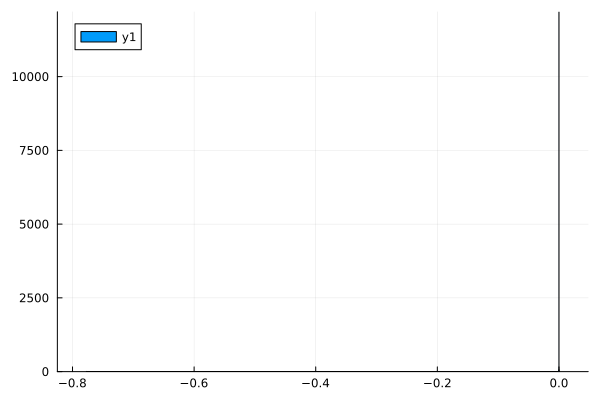

In [254]:
histogram(e4[1] |> vec)

In [256]:
maximum(maximum.(e4))

5.492935276016381e-7

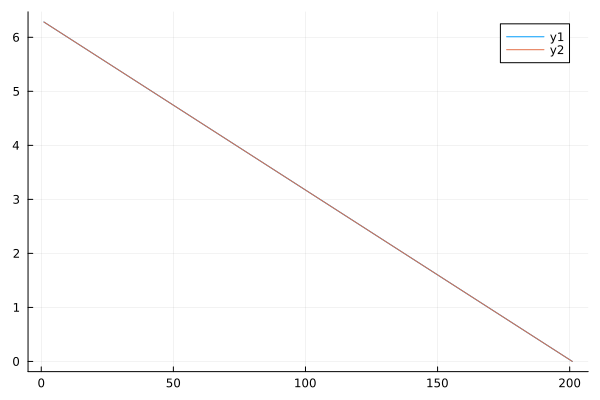

In [238]:
plot(mod.(p01, 2*pi))
plot!(mod.(angle.(phase_to_potential(phases, [0.0,], spk_args=sa, offset=0.0)), 2*pi))